In [15]:
import pandas as pd
import numpy as np
import spacy
import re
import collections
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [16]:
CSV_PATH = r"C:\Users\Arbnor\Desktop\BA\validation_attention.csv"
SPACY_MODEL = "en_core_web_sm"
SHOW_DEBUG = False  # True = zeigt Wort-Level-Analyse für jede Frage aus dem Validationdatensatz


In [17]:
POS_TRANSLATION = {
    "NOUN": "Nomen",
    "VERB": "Verb",
    "ADJ": "Adjektiv",
    "PUNCT": "Satzzeichen",
    "PRON": "Pronomen",
    "DET": "Determinator",
    "ADV": "Adverb",
    "OTHER": "Andere",
    "WH": "Fragewort"
}

WH_SET = {"what", "which", "who", "whom", "whose", "where", "when", "why", "how"}
NEW_CHUNK = re.compile(r"^[▁]|^[\?\!\,\.\:\;]$")


In [18]:
def pos_bucket(token_str, pos_tag):
    """Zuordnung zu POS-Buckets basierend auf Token-String und POS-Tag."""
    low = token_str.lower()
    if low in WH_SET:
        return "WH"
    if pos_tag == "ADJ":
        return "ADJ"
    if pos_tag in ("VERB", "AUX"):
        return "VERB"
    if pos_tag == "NOUN":
        return "NOUN"
    if pos_tag == "PRON":
        return "PRON"
    if pos_tag == "DET":
        return "DET"
    if pos_tag == "ADV":
        return "ADV"
    if pos_tag == "PUNCT" or re.fullmatch(r"[\?\!\,\.\:\;]", token_str):
        return "PUNCT"
    return "OTHER"

In [19]:
def rebuild_words(tok_series, score_series):
    """Fasst Sub-Tokens (SentencePiece) zu vollständigen Wörtern zusammen."""
    words, scores = [], []
    cur_word, cur_score = "", 0.0

    for tok, sc in zip(tok_series, score_series):
        if NEW_CHUNK.match(tok):
            if cur_word:
                words.append(cur_word)
                scores.append(cur_score)
            if tok.startswith("▁"):
                cur_word = tok.lstrip("▁")
                cur_score = sc
            else:
                words.append(tok)
                scores.append(sc)
                cur_word, cur_score = "", 0.0
        else:
            cur_word += tok
            cur_score += sc

    if cur_word:
        words.append(cur_word)
        scores.append(cur_score)

    return words, scores

In [20]:
def process_attention_data(df, nlp):
    """Berechnet POS-basierten Attention-Anteil pro Sample."""
    per_sample_percent = []

    for sid, group in df.groupby("sample_id", sort=False):
        words, scores = rebuild_words(group["token"], group["score"])
        doc = nlp(" ".join(words))

        bucket_scores = collections.defaultdict(float)
        for word, score, spacy_tok in zip(words, scores, doc):
            bucket = pos_bucket(word, spacy_tok.pos_)
            bucket_scores[bucket] += score

        total = sum(scores)
        percent = {k: v / total for k, v in bucket_scores.items()}
        percent["sample_id"] = sid
        per_sample_percent.append(percent)

        if SHOW_DEBUG:
            print(f"\n=== sample_id {sid} : \"{group.question.iloc[0]}\" ===")
            print(f"{'Word':<18} {'Bucket':<6} {'Score':>10}")
            for w, sc, sp in zip(words, scores, doc):
                print(f"{w:<18} {pos_bucket(w, sp.pos_):<6} {sc:10.6f}")
            print("  -- Prozentanteile:")
            for k, v in sorted(percent.items(), key=lambda x: -x[1] if x[0] != "sample_id" else 1):
                if k != "sample_id":
                    print(f"    {k:<6}: {v * 100:6.2f} %")

    return pd.DataFrame(per_sample_percent).fillna(0.0)

In [21]:
def plot_attention_distribution(mean_percent, translated=False):
    """Plottet den durchschnittlichen Attention-Anteil."""
    if translated:
        mean_percent = mean_percent.rename(index=POS_TRANSLATION)

    plt.figure(figsize=(8, 4))
    mean_percent.plot(kind="bar", color="#4C72B0")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.ylabel("Durchschnittlicher Attention-Anteil")
    plt.xlabel("Wortart")
    plt.title("Durchschnittlicher Attention-Anteil pro Wortart (Validierungsdatensatz)")
    plt.tight_layout()
    plt.show()

In [22]:
def main():
    # Daten laden
    df = pd.read_csv(CSV_PATH)
    nlp = spacy.load(SPACY_MODEL, disable=["ner", "parser"])

    # Attention je Wortart pro Sample
    perc_df = process_attention_data(df, nlp)

    # Durchschnitt über alle Samples
    bucket_cols = sorted([col for col in perc_df.columns if col != "sample_id"])
    mean_percent = perc_df[bucket_cols].mean().sort_values(ascending=False)

    print("\n=== Durchschnittlicher Attention-Anteil je Wortart ===")
    for cat, val in mean_percent.items():
        print(f"{cat:<6}: {val * 100:6.2f} %")

    # Diagramm erzeugen
    plot_attention_distribution(mean_percent, translated=True)


=== Durchschnittlicher Attention-Anteil je Wortart ===
NOUN  :  21.50 %
VERB  :  19.98 %
ADJ   :  19.21 %
PUNCT :  14.16 %
WH    :  12.99 %
OTHER :   6.42 %
DET   :   4.99 %
ADV   :   0.65 %
PRON  :   0.10 %


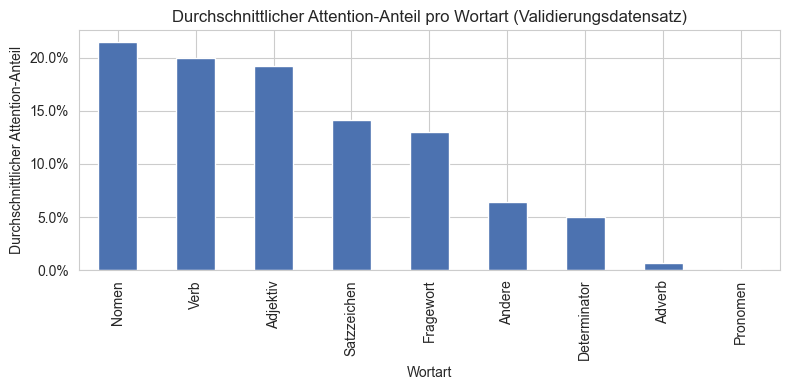

In [23]:
if __name__ == "__main__":
    main()